In [81]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from glob import glob
import os

In [82]:
glob('surprisals/DC-pythia/*')[:5]

['surprisals/DC-pythia/arch_pythia-160m-ngram_2-contextfunc_lossy-0.125',
 'surprisals/DC-pythia/arch_pythia-1b-ngram_20-contextfunc_delete',
 'surprisals/DC-pythia/arch_pythia-1b-ngram_10-contextfunc_lossy-0.0625',
 'surprisals/DC-pythia/arch_pythia-1b-ngram_7-contextfunc_lossy-0.25',
 'surprisals/DC-pythia/arch_pythia-1.4b-ngram_3-contextfunc_lossy-0.5']

In [83]:
def load_experiment_data(path):
    result = []
    for dirpath in glob(os.path.join(path, '*')):
        if not os.path.isdir(dirpath):
            continue
        exp = dirpath.split('/')[-1].replace('-hf', '')
        model, size, _, = exp.split('_')[1].split('-')
        ngram = exp.split('_')[2].split('-')[0]
        contextfunc = exp.split('contextfunc_')[-1]
        d_ = {
            'model': model,
            'size': size,
            'ngram': ngram,
            'contextfunc': contextfunc
        }
        
        with open(os.path.join(dirpath, 'likelihood.txt')) as f:
            lines = f.readlines()
            for line in lines[:3]:
                key, value = line.strip().split(': ')
                d_[key] = float(value)
        
        
        with open(os.path.join(dirpath, 'eval.txt')) as f:
            line = f.readlines()[0].strip("{}").replace('"', "")
            key, value = line.strip().split(': ')
            d_[key] = float(value)
        
        result.append(d_)
        
    df = pd.DataFrame(result)
    return df

In [84]:
mamba_df = load_experiment_data('surprisals/DC-mamba')
pythia_df = load_experiment_data('surprisals/DC-pythia')

In [85]:
mamba_df.sort_values('delta_linear_fit_logLik', ascending=False)

,model,size,ngram,contextfunc,linear_fit_logLik,delta_linear_fit_logLik,delta_linear_fit_chi_p,PPL
65,mamba,370m,2,delete,-5.942793,0.007435,0.0,359.931618
136,mamba,790m,2,delete,-5.942927,0.007300,0.0,353.142378
130,mamba,1.4b,2,delete,-5.942935,0.007292,0.0,336.875576
116,mamba,130m,2,delete,-5.943003,0.007224,0.0,387.745736
53,mamba,2.8b,2,delete,-5.943217,0.007010,0.0,340.448331
...,...,...,...,...,...,...,...,...
120,mamba,2.8b,20,lossy-0.25,-5.945105,0.005122,0.0,52.695219
54,mamba,2.8b,20,lossy-0.5,-5.945107,0.005120,0.0,52.983243
47,mamba,2.8b,20,delete,-5.945108,0.005120,0.0,53.128593
124,mamba,2.8b,1000,delete,-5.945113,0.005115,0.0,51.075546


In [86]:
pythia_df.sort_values('delta_linear_fit_logLik', ascending=False)

,model,size,ngram,contextfunc,linear_fit_logLik,delta_linear_fit_logLik,delta_linear_fit_chi_p,PPL
53,pythia,70m,20,lossy-0.5,-5.942575,0.007652,0.0,134.616018
165,pythia,70m,1000,delete,-5.942582,0.007646,0.0,132.258720
128,pythia,70m,3,lossy-0.5,-5.942584,0.007644,0.0,269.023969
90,pythia,70m,7,lossy-0.125,-5.942592,0.007635,0.0,151.197154
11,pythia,70m,20,delete,-5.942593,0.007634,0.0,134.858502
...,...,...,...,...,...,...,...,...
45,pythia,2.8b,20,delete,-5.944798,0.005429,0.0,55.431610
99,pythia,2.8b,20,lossy-0.0625,-5.944803,0.005425,0.0,54.225574
104,pythia,2.8b,20,lossy-0.25,-5.944809,0.005418,0.0,54.929532
38,pythia,2.8b,20,lossy-0.125,-5.944811,0.005417,0.0,54.615369


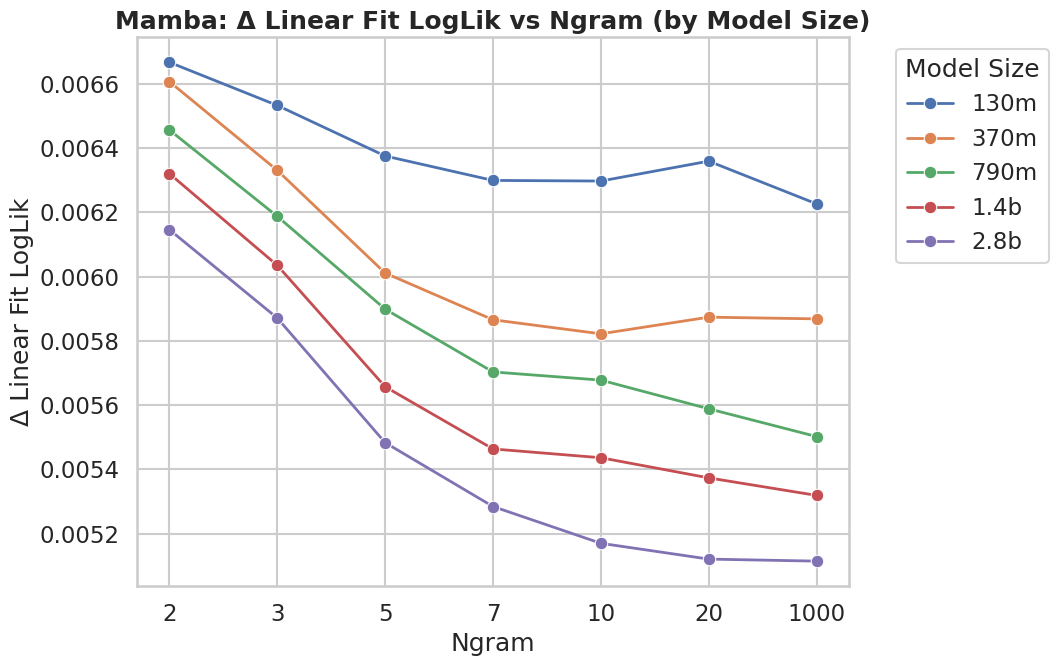

In [87]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def to_num(s):
    """Convert size strings like '130m', '1.4b' to numeric values."""
    m = re.match(r"([\d.]+)\s*([mbMB])", str(s))
    if not m:
        return float("nan")
    val, unit = float(m.group(1)), m.group(2).lower()
    return val * (1e6 if unit == "m" else 1e9)

def plot_metric_vs_ngram(df, model_name, metric="delta_linear_fit_logLik", 
                         figsize=(11, 7), save_path=None):
    """
    Plot a metric vs ngram for different model sizes.
    
    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame with columns: size, ngram, and the metric to plot
    model_name : str
        Name of the model (e.g., "Mamba", "Pythia")
    metric : str
        Column name to plot on y-axis (default: "delta_linear_fit_logLik")
    figsize : tuple
        Figure size (width, height)
    save_path : str, optional
        Path to save the figure
    """
    df = df.copy()
    df["size_num"] = df["size"].apply(to_num)
    
    # Sort legend (hue) by numeric size
    size_order = (
        df[["size", "size_num"]]
        .dropna()
        .drop_duplicates()
        .sort_values("size_num")["size"]
        .tolist()
    )
    
    # Sort ngram numerically, then convert to strings for plotting
    df["ngram"] = pd.to_numeric(df["ngram"], errors="coerce")
    ngram_order = sorted(df["ngram"].dropna().unique())
    df["ngram_str"] = pd.Categorical(df["ngram"].astype(int).astype(str),
                                     categories=[str(x) for x in ngram_order],
                                     ordered=True)
    
    # Metric labels
    metric_labels = {
        "delta_linear_fit_logLik": "Δ Linear Fit LogLik",
        "perplexity": "Perplexity (PPL)",
        "delta_logLik": "Δ LogLik",
        "linear_fit_logLik": "Linear Fit LogLik"
    }
    
    ylabel = metric_labels.get(metric, metric.replace("_", " ").title())
    
    # Plot
    sns.set_theme(style="whitegrid", context="talk")
    plt.figure(figsize=figsize)
    
    sns.lineplot(
        data=df.sort_values(["size_num", "ngram"]),
        x="ngram_str",
        y=metric,
        hue="size",
        hue_order=size_order,
        errorbar=None,
        linewidth=2,
        marker="o"
    )
    
    plt.xlabel("Ngram")
    plt.ylabel(ylabel)
    plt.title(f"{model_name}: {ylabel} vs Ngram (by Model Size)", weight="bold")
    plt.legend(title="Model Size", frameon=True, bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    
    plt.show()

# Plot delta_linear_fit_logLik for Mamba
plot_metric_vs_ngram(mamba_df, "Mamba", metric="delta_linear_fit_logLik")

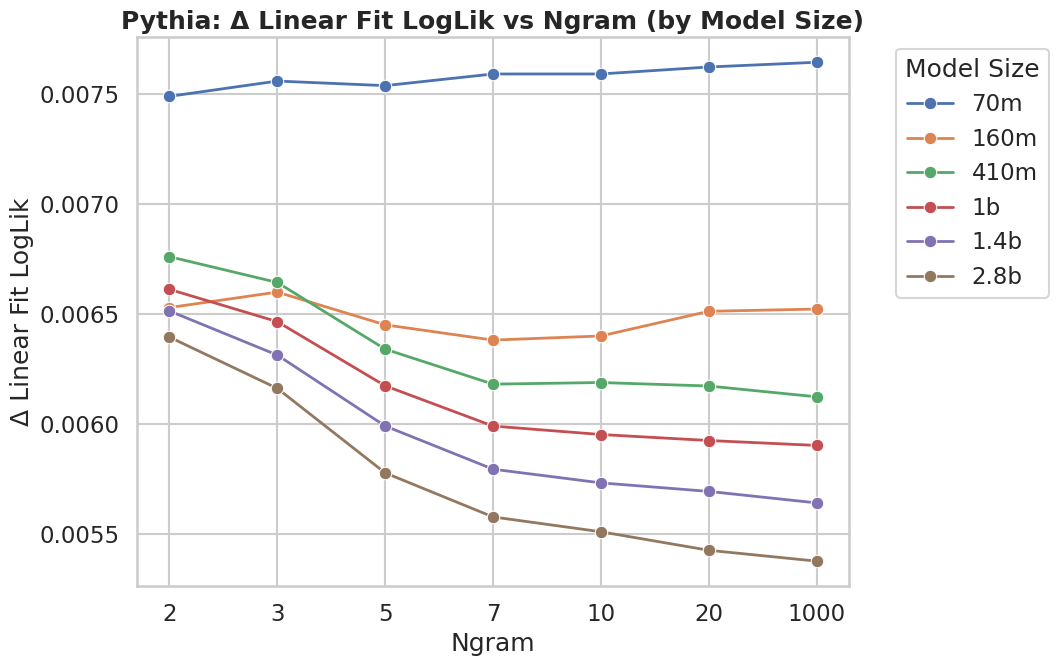

In [88]:
# Plot delta_linear_fit_logLik for Pythia
plot_metric_vs_ngram(pythia_df, "Pythia", metric="delta_linear_fit_logLik")

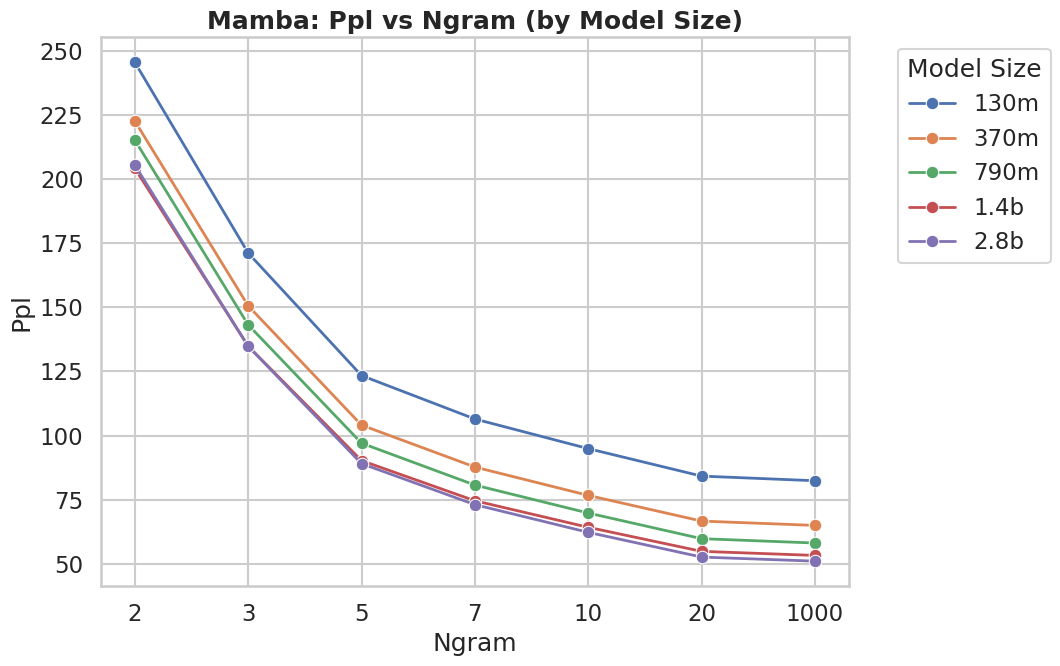

In [89]:
# Plot Perplexity (PPL) for Mamba
plot_metric_vs_ngram(mamba_df, "Mamba", metric="PPL")

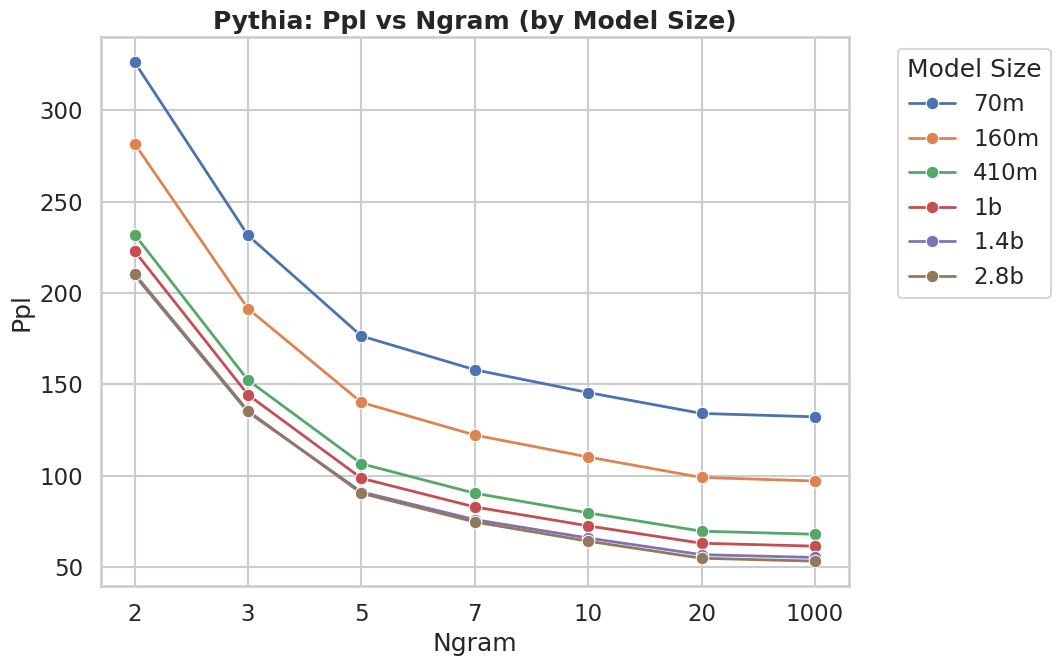

In [90]:
# Plot Perplexity (PPL) for Pythia
plot_metric_vs_ngram(pythia_df, "Pythia", metric="PPL")

In [91]:
# Additional visualizations - you can explore other metrics
# Available metrics in the dataframe:
print("Available columns in mamba_df:", mamba_df.columns.tolist())
print("\nAvailable columns in pythia_df:", pythia_df.columns.tolist())

Available columns in mamba_df: ['model', 'size', 'ngram', 'contextfunc', 'linear_fit_logLik', 'delta_linear_fit_logLik', 'delta_linear_fit_chi_p', 'PPL']

Available columns in pythia_df: ['model', 'size', 'ngram', 'contextfunc', 'linear_fit_logLik', 'delta_linear_fit_logLik', 'delta_linear_fit_chi_p', 'PPL']


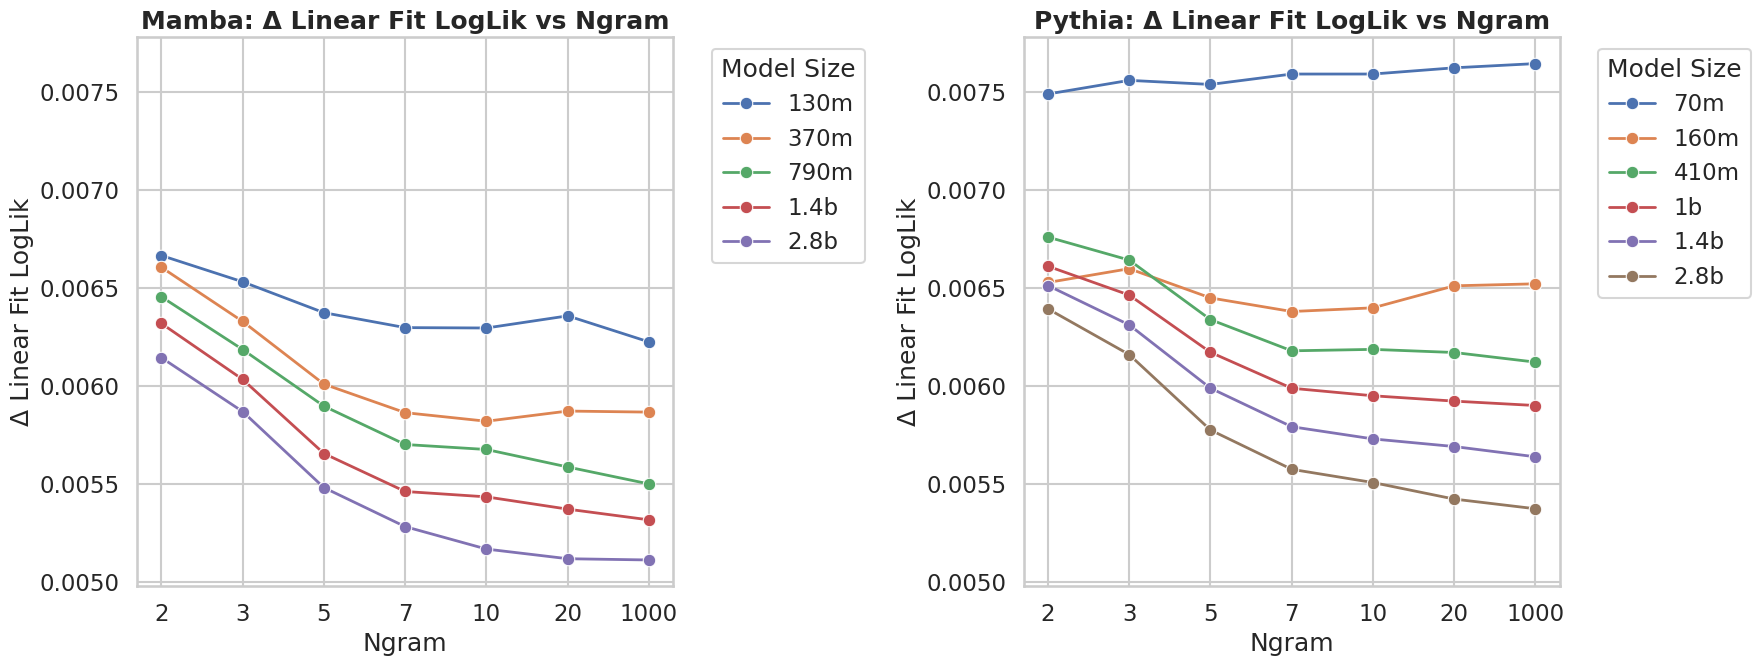

In [100]:
# Compare Mamba vs Pythia side by side
def plot_comparison(mamba_df, pythia_df, metric="delta_linear_fit_logLik", figsize=(18, 7)):
    """
    Plot side-by-side comparison of Mamba and Pythia for a given metric.
    
    Parameters:
    -----------
    mamba_df : pd.DataFrame
        Mamba experiment data
    pythia_df : pd.DataFrame
        Pythia experiment data
    metric : str
        Column name to plot on y-axis
    figsize : tuple
        Figure size (width, height)
    """
    metric_labels = {
        "delta_linear_fit_logLik": "Δ Linear Fit LogLik",
        "perplexity": "Perplexity (PPL)",
        "delta_logLik": "Δ LogLik",
        "linear_fit_logLik": "Linear Fit LogLik"
    }
    
    ylabel = metric_labels.get(metric, metric.replace("_", " ").title())
    
    fig, axes = plt.subplots(1, 2, figsize=figsize)
    sns.set_theme(style="whitegrid", context="talk")
    
    # Get y-axis limits across both datasets for consistent scaling
    all_values = []
    
    for idx, (df, model_name, ax) in enumerate([(mamba_df, "Mamba", axes[0]), 
                                                  (pythia_df, "Pythia", axes[1])]):
        df = df.copy()
        df["size_num"] = df["size"].apply(to_num)
        
        size_order = (
            df[["size", "size_num"]]
            .dropna()
            .drop_duplicates()
            .sort_values("size_num")["size"]
            .tolist()
        )
        
        df["ngram"] = pd.to_numeric(df["ngram"], errors="coerce")
        ngram_order = sorted(df["ngram"].dropna().unique())
        df["ngram_str"] = pd.Categorical(df["ngram"].astype(int).astype(str),
                                         categories=[str(x) for x in ngram_order],
                                         ordered=True)
        
        all_values.extend(df[metric].dropna().tolist())
        
        sns.lineplot(
            data=df.sort_values(["size_num", "ngram"]),
            x="ngram_str",
            y=metric,
            hue="size",
            hue_order=size_order,
            errorbar=None,
            linewidth=2,
            marker="o",
            ax=ax
        )
        
        ax.set_xlabel("Ngram")
        ax.set_ylabel(ylabel)
        ax.set_title(f"{model_name}: {ylabel} vs Ngram", weight="bold")
        
        # Move legend outside to avoid overlapping and keep alignment consistent
        ax.legend(title="Model Size", frameon=True, bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Set same y-axis limits for both plots for better comparison
    if all_values:
        y_min, y_max = min(all_values), max(all_values)
        y_range = y_max - y_min
        padding = y_range * 0.05
        for ax in axes:
            ax.set_ylim(y_min - padding, y_max + padding)
    
    plt.tight_layout()
    plt.show()

# Compare delta_linear_fit_logLik
plot_comparison(mamba_df, pythia_df, metric="delta_linear_fit_logLik")

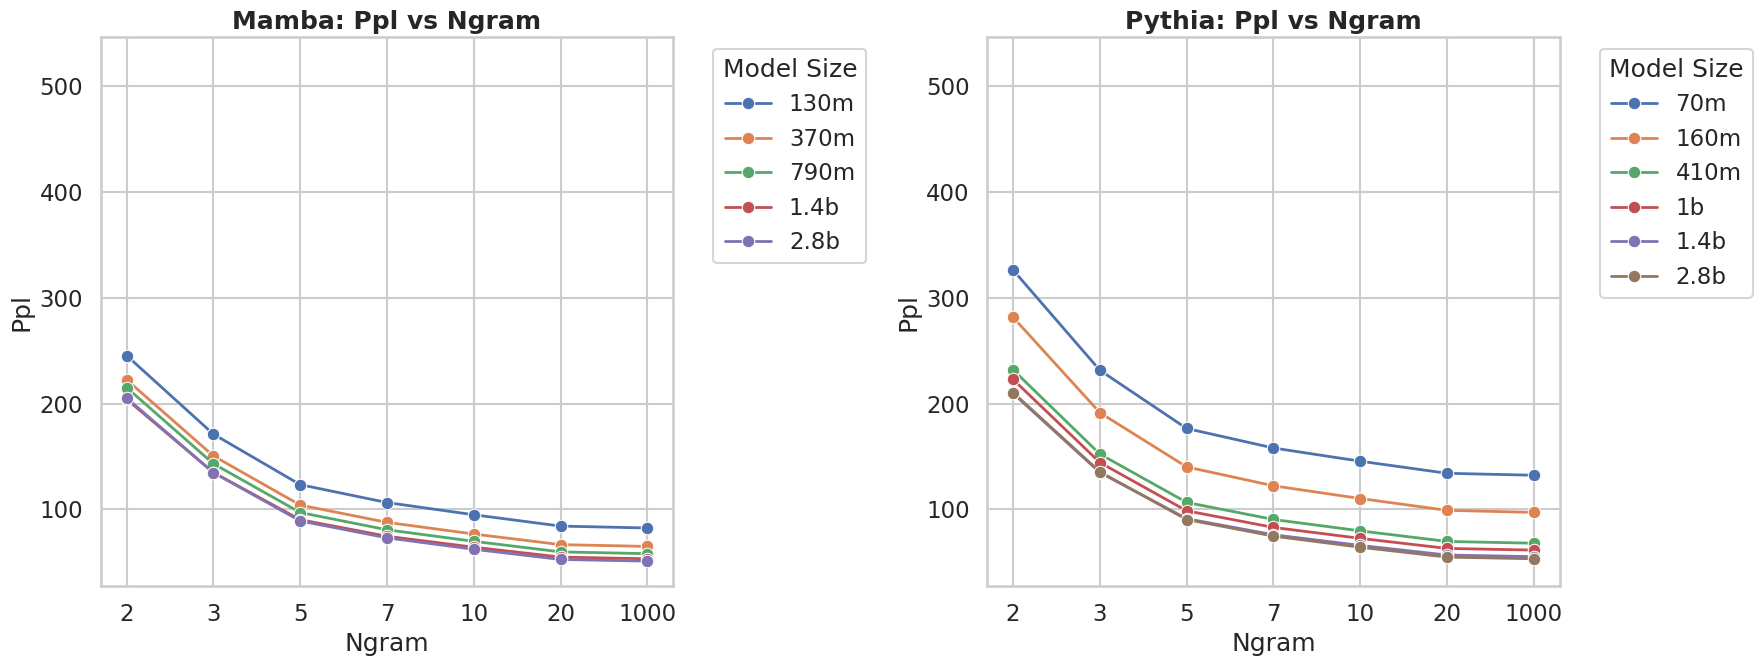

In [101]:
# Compare Perplexity (PPL) - side by side
plot_comparison(mamba_df, pythia_df, metric="PPL")